<a href="https://www.kaggle.com/code/abhigtm19/five-tuning-renet-50-for-five-grained-dog-breeds?scriptVersionId=276379888" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import shutil # For copying files
import glob
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# --- Parameters ---
# This is the standard, correct path *after* you "Add data" in Kaggle
SOURCE_DATA_DIR = '/kaggle/input/stanford-dogs-dataset/images/Images'

# This is a *new* folder we create in our "working" directory
# to hold our small subset.
BASE_DIR = '/kaggle/working/dog_subset'

IMG_SIZE = 224 # ResNet50 was trained on 224x224
BATCH_SIZE = 64 # Good size for a Kaggle GPU/TPU
NUM_BREEDS = 15 # As specified in the assignment

/usr/local/lib/python3.12/site-packages/jax/_src/cloud_tpu_init.py:93: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


In [2]:
print("--- Task 1: Data Handling ---")

# Get a list of all breed directories from the *input* path
all_breeds = sorted(glob.glob(os.path.join(SOURCE_DATA_DIR, 'n*')))

# Select the first 15 breeds.
selected_breeds = all_breeds[:NUM_BREEDS]
selected_breed_names = [os.path.basename(p) for p in selected_breeds]

print(f"Selected {len(selected_breeds)} breeds:")
for name in selected_breed_names:
    print(f"- {name}")

# Create the new directory structure in our *working* directory
if os.path.exists(BASE_DIR):
    shutil.rmtree(BASE_DIR) # Start fresh
os.makedirs(BASE_DIR, exist_ok=True)

# Copy the selected breed images from the input dir to the working dir
for breed_path in selected_breeds:
    breed_name = os.path.basename(breed_path)
    print(f"Copying {breed_name}...")
    shutil.copytree(breed_path, os.path.join(BASE_DIR, breed_name))

print("\nDataset subset created successfully.")

# --- Define Data Generators ---
VALIDATION_SPLIT = 0.3 # 15% validation, 15% test

# 1. Training Generator
# We define ONE generator with the split and augmentations
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    channel_shift_range=10.0,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=VALIDATION_SPLIT # This reserves 30% of data
)

# 2. Load Training data (70%)
train_generator = train_datagen.flow_from_directory(
    BASE_DIR, # We point to our *working* directory
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='training' # Specify this is the training set
)

# 3. Load Validation data (30%)
# *** We MUST use the *same* train_datagen object ***
validation_generator = train_datagen.flow_from_directory(
    BASE_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='validation', # Specify this is the validation set
    shuffle=False
)

# 4. Manually split the 30% validation set into 15% val and 15% test
print("\nCreating manual Test Set...")
validation_generator.reset()

X_val_test, y_val_test = [], []
for _ in range(len(validation_generator)):
    X, y = next(validation_generator) # <-- THIS IS THE CORRECTED LINE
    X_val_test.append(X)
    y_val_test.append(y)

# This will now work
X_val_test = np.concatenate(X_val_test)
y_val_test = np.concatenate(y_val_test)

# Split 50/50
split_point = int(0.5 * len(y_val_test))
X_val, y_val = X_val_test[:split_point], y_val_test[:split_point]
X_test, y_test = X_val_test[split_point:], y_val_test[split_point:]

print(f"Total training images: {train_generator.n}")
print(f"Total validation images: {len(X_val)}")
print(f"Total test images: {len(X_test)}")

# Get class names
CLASS_NAMES = list(train_generator.class_indices.keys())

--- Task 1: Data Handling ---
Selected 15 breeds:
- n02085620-Chihuahua
- n02085782-Japanese_spaniel
- n02085936-Maltese_dog
- n02086079-Pekinese
- n02086240-Shih-Tzu
- n02086646-Blenheim_spaniel
- n02086910-papillon
- n02087046-toy_terrier
- n02087394-Rhodesian_ridgeback
- n02088094-Afghan_hound
- n02088238-basset
- n02088364-beagle
- n02088466-bloodhound
- n02088632-bluetick
- n02089078-black-and-tan_coonhound
Copying n02085620-Chihuahua...


Copying n02085782-Japanese_spaniel...


Copying n02085936-Maltese_dog...


Copying n02086079-Pekinese...


Copying n02086240-Shih-Tzu...


Copying n02086646-Blenheim_spaniel...


Copying n02086910-papillon...


Copying n02087046-toy_terrier...


Copying n02087394-Rhodesian_ridgeback...


Copying n02088094-Afghan_hound...


Copying n02088238-basset...


Copying n02088364-beagle...


Copying n02088466-bloodhound...


Copying n02088632-bluetick...


Copying n02089078-black-and-tan_coonhound...



Dataset subset created successfully.
Found 1972 images belonging to 15 classes.


Found 834 images belonging to 15 classes.



Creating manual Test Set...


Total training images: 1972
Total validation images: 417
Total test images: 417


In [3]:
print("\n--- Task 2: Building ResNet50 Model ---")

# 1. Load ResNet50 base
base_model = ResNet50(
    weights='imagenet', 
    include_top=False, 
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# 2. Create the custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_BREEDS, activation='softmax')(x) # 15 classes

# 3. Combine into the final model
model = Model(inputs=base_model.input, outputs=predictions)

model.summary()


--- Task 2: Building ResNet50 Model ---


2025-11-12 03:04:39.443652: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


       0/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step

 7938048/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

24887296/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

36012032/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

49053696/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

64880640/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

80257024/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

92987392/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,646,543 (94.02 MB)

 Trainable params: 24,592,399 (93.81 MB)

 Non-trainable params: 54,144 (211.50 KB)

In [4]:
print("\n--- Task 3: Training ---")

# Define Callbacks
checkpoint_cb = ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss")
early_stopping_cb = EarlyStopping(patience=10, restore_best_weights=True, monitor="val_loss")
reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# --- Phase 1: Train the Head ---
print("\n--- Phase 1: Training the custom head ---")

# 1. Freeze the base model
base_model.trainable = False

# 2. Compile with a low learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-3), # Higher LR for the new head
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 3. Train
history_phase1 = model.fit(
    train_generator,
    epochs=10, # 10 epochs
    validation_data=(X_val, y_val),
    callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr_cb]
)

# --- Phase 2: Fine-Tuning ---
print("\n--- Phase 2: Fine-tuning the top ResNet blocks ---")

# 1. Unfreeze the top ~30 layers
base_model.trainable = True
fine_tune_at = 143 # Unfreeze from layer 143 (block 5) onwards
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# 2. Re-compile with a very low learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5), # Very low LR for fine-tuning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 3. Continue training
history_phase2 = model.fit(
    train_generator,
    epochs=30, # Continue for 20-30 more epochs
    initial_epoch=history_phase1.epoch[-1], # Start from where we left off
    validation_data=(X_val, y_val),
    callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr_cb]
)

# Load the best model saved
model = tf.keras.models.load_model("best_model.keras")
print("\nBest model loaded.")


--- Task 3: Training ---

--- Phase 1: Training the custom head ---


Epoch 1/10


 1/31 ━━━━━━━━━━━━━━━━━━━━ 2:55 6s/step - accuracy: 0.0469 - loss: 4.2635

 2/31 ━━━━━━━━━━━━━━━━━━━━ 18s 643ms/step - accuracy: 0.0859 - loss: 3.9641

 3/31 ━━━━━━━━━━━━━━━━━━━━ 18s 654ms/step - accuracy: 0.1302 - loss: 3.7011

 4/31 ━━━━━━━━━━━━━━━━━━━━ 17s 654ms/step - accuracy: 0.1670 - loss: 3.4860

 5/31 ━━━━━━━━━━━━━━━━━━━━ 17s 659ms/step - accuracy: 0.1973 - loss: 3.3082

 6/31 ━━━━━━━━━━━━━━━━━━━━ 16s 666ms/step - accuracy: 0.2243 - loss: 3.1617

 7/31 ━━━━━━━━━━━━━━━━━━━━ 15s 665ms/step - accuracy: 0.2484 - loss: 3.0336

 8/31 ━━━━━━━━━━━━━━━━━━━━ 15s 664ms/step - accuracy: 0.2711 - loss: 2.9164

 9/31 ━━━━━━━━━━━━━━━━━━━━ 14s 665ms/step - accuracy: 0.2929 - loss: 2.8088

10/31 ━━━━━━━━━━━━━━━━━━━━ 13s 666ms/step - accuracy: 0.3128 - loss: 2.7129

11/31 ━━━━━━━━━━━━━━━━━━━━ 13s 664ms/step - accuracy: 0.3307 - loss: 2.6263

12/31 ━━━━━━━━━━━━━━━━━━━━ 12s 663ms/step - accuracy: 0.3470 - loss: 2.5487

13/31 ━━━━━━━━━━━━━━━━━━━━ 11s 663ms/step - accuracy: 0.3624 - loss: 2.4769

14/31 ━━━━━━━━━━━━━━━━━━━━ 11s 659ms/step - accuracy: 0.3761 - loss: 2.4129

15/31 ━━━━━━━━━━━━━━━━━━━━ 10s 659ms/step - accuracy: 0.3892 - loss: 2.3527

16/31 ━━━━━━━━━━━━━━━━━━━━ 9s 658ms/step - accuracy: 0.4015 - loss: 2.2969 

17/31 ━━━━━━━━━━━━━━━━━━━━ 9s 658ms/step - accuracy: 0.4130 - loss: 2.2457

18/31 ━━━━━━━━━━━━━━━━━━━━ 8s 657ms/step - accuracy: 0.4238 - loss: 2.1977

19/31 ━━━━━━━━━━━━━━━━━━━━ 7s 657ms/step - accuracy: 0.4342 - loss: 2.1523

20/31 ━━━━━━━━━━━━━━━━━━━━ 7s 658ms/step - accuracy: 0.4441 - loss: 2.1098

21/31 ━━━━━━━━━━━━━━━━━━━━ 6s 657ms/step - accuracy: 0.4532 - loss: 2.0699

22/31 ━━━━━━━━━━━━━━━━━━━━ 5s 657ms/step - accuracy: 0.4619 - loss: 2.0323

23/31 ━━━━━━━━━━━━━━━━━━━━ 5s 658ms/step - accuracy: 0.4703 - loss: 1.9967

24/31 ━━━━━━━━━━━━━━━━━━━━ 4s 659ms/step - accuracy: 0.4781 - loss: 1.9631

25/31 ━━━━━━━━━━━━━━━━━━━━ 3s 659ms/step - accuracy: 0.4855 - loss: 1.9310

26/31 ━━━━━━━━━━━━━━━━━━━━ 3s 660ms/step - accuracy: 0.4925 - loss: 1.9011

27/31 ━━━━━━━━━━━━━━━━━━━━ 2s 659ms/step - accuracy: 0.4991 - loss: 1.8729

28/31 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step - accuracy: 0.5055 - loss: 1.8460

29/31 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step - accuracy: 0.5116 - loss: 1.8201

30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 659ms/step - accuracy: 0.5175 - loss: 1.7954

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 660ms/step - accuracy: 0.5231 - loss: 1.7719

31/31 ━━━━━━━━━━━━━━━━━━━━ 32s 876ms/step - accuracy: 0.6897 - loss: 1.0685 - val_accuracy: 0.7746 - val_loss: 0.7647 - learning_rate: 0.0010


Epoch 2/10


 1/31 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.7969 - loss: 0.6296

 2/31 ━━━━━━━━━━━━━━━━━━━━ 14s 514ms/step - accuracy: 0.7950 - loss: 0.5949

 3/31 ━━━━━━━━━━━━━━━━━━━━ 17s 635ms/step - accuracy: 0.8004 - loss: 0.5721

 4/31 ━━━━━━━━━━━━━━━━━━━━ 17s 651ms/step - accuracy: 0.8062 - loss: 0.5565

 5/31 ━━━━━━━━━━━━━━━━━━━━ 16s 652ms/step - accuracy: 0.8067 - loss: 0.5487

 6/31 ━━━━━━━━━━━━━━━━━━━━ 16s 647ms/step - accuracy: 0.8080 - loss: 0.5415

 7/31 ━━━━━━━━━━━━━━━━━━━━ 15s 649ms/step - accuracy: 0.8095 - loss: 0.5383

 8/31 ━━━━━━━━━━━━━━━━━━━━ 15s 652ms/step - accuracy: 0.8113 - loss: 0.5338

 9/31 ━━━━━━━━━━━━━━━━━━━━ 14s 650ms/step - accuracy: 0.8130 - loss: 0.5296

10/31 ━━━━━━━━━━━━━━━━━━━━ 13s 652ms/step - accuracy: 0.8145 - loss: 0.5264

11/31 ━━━━━━━━━━━━━━━━━━━━ 12s 650ms/step - accuracy: 0.8159 - loss: 0.5227

12/31 ━━━━━━━━━━━━━━━━━━━━ 12s 651ms/step - accuracy: 0.8172 - loss: 0.5191

13/31 ━━━━━━━━━━━━━━━━━━━━ 11s 651ms/step - accuracy: 0.8186 - loss: 0.5153

14/31 ━━━━━━━━━━━━━━━━━━━━ 11s 650ms/step - accuracy: 0.8202 - loss: 0.5104

15/31 ━━━━━━━━━━━━━━━━━━━━ 10s 648ms/step - accuracy: 0.8220 - loss: 0.5054

16/31 ━━━━━━━━━━━━━━━━━━━━ 9s 649ms/step - accuracy: 0.8237 - loss: 0.5005 

17/31 ━━━━━━━━━━━━━━━━━━━━ 9s 649ms/step - accuracy: 0.8253 - loss: 0.4960

18/31 ━━━━━━━━━━━━━━━━━━━━ 8s 648ms/step - accuracy: 0.8268 - loss: 0.4916

19/31 ━━━━━━━━━━━━━━━━━━━━ 7s 647ms/step - accuracy: 0.8284 - loss: 0.4869

20/31 ━━━━━━━━━━━━━━━━━━━━ 7s 649ms/step - accuracy: 0.8297 - loss: 0.4829

21/31 ━━━━━━━━━━━━━━━━━━━━ 6s 649ms/step - accuracy: 0.8309 - loss: 0.4792

22/31 ━━━━━━━━━━━━━━━━━━━━ 5s 649ms/step - accuracy: 0.8322 - loss: 0.4753

23/31 ━━━━━━━━━━━━━━━━━━━━ 5s 648ms/step - accuracy: 0.8334 - loss: 0.4717

24/31 ━━━━━━━━━━━━━━━━━━━━ 4s 649ms/step - accuracy: 0.8346 - loss: 0.4685

25/31 ━━━━━━━━━━━━━━━━━━━━ 3s 649ms/step - accuracy: 0.8356 - loss: 0.4656

26/31 ━━━━━━━━━━━━━━━━━━━━ 3s 650ms/step - accuracy: 0.8366 - loss: 0.4626

27/31 ━━━━━━━━━━━━━━━━━━━━ 2s 652ms/step - accuracy: 0.8375 - loss: 0.4599

28/31 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step - accuracy: 0.8383 - loss: 0.4575

29/31 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step - accuracy: 0.8391 - loss: 0.4551

30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 654ms/step - accuracy: 0.8398 - loss: 0.4529

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 655ms/step - accuracy: 0.8405 - loss: 0.4508

31/31 ━━━━━━━━━━━━━━━━━━━━ 26s 815ms/step - accuracy: 0.8616 - loss: 0.3862 - val_accuracy: 0.8321 - val_loss: 0.5373 - learning_rate: 0.0010


Epoch 3/10


 1/31 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.9219 - loss: 0.2999

 2/31 ━━━━━━━━━━━━━━━━━━━━ 20s 691ms/step - accuracy: 0.9219 - loss: 0.3079

 3/31 ━━━━━━━━━━━━━━━━━━━━ 18s 674ms/step - accuracy: 0.9149 - loss: 0.3260

 4/31 ━━━━━━━━━━━━━━━━━━━━ 17s 665ms/step - accuracy: 0.9128 - loss: 0.3261

 5/31 ━━━━━━━━━━━━━━━━━━━━ 17s 657ms/step - accuracy: 0.9133 - loss: 0.3211

 6/31 ━━━━━━━━━━━━━━━━━━━━ 16s 671ms/step - accuracy: 0.9117 - loss: 0.3199

 7/31 ━━━━━━━━━━━━━━━━━━━━ 16s 672ms/step - accuracy: 0.9103 - loss: 0.3180

 8/31 ━━━━━━━━━━━━━━━━━━━━ 15s 673ms/step - accuracy: 0.9091 - loss: 0.3172

 9/31 ━━━━━━━━━━━━━━━━━━━━ 14s 674ms/step - accuracy: 0.9072 - loss: 0.3166

10/31 ━━━━━━━━━━━━━━━━━━━━ 14s 672ms/step - accuracy: 0.9052 - loss: 0.3186

11/31 ━━━━━━━━━━━━━━━━━━━━ 13s 670ms/step - accuracy: 0.9038 - loss: 0.3191

12/31 ━━━━━━━━━━━━━━━━━━━━ 12s 668ms/step - accuracy: 0.9028 - loss: 0.3193

13/31 ━━━━━━━━━━━━━━━━━━━━ 12s 669ms/step - accuracy: 0.9023 - loss: 0.3187

14/31 ━━━━━━━━━━━━━━━━━━━━ 11s 669ms/step - accuracy: 0.9019 - loss: 0.3178

15/31 ━━━━━━━━━━━━━━━━━━━━ 10s 668ms/step - accuracy: 0.9014 - loss: 0.3176

16/31 ━━━━━━━━━━━━━━━━━━━━ 10s 669ms/step - accuracy: 0.9012 - loss: 0.3170

17/31 ━━━━━━━━━━━━━━━━━━━━ 9s 661ms/step - accuracy: 0.9010 - loss: 0.3162 

18/31 ━━━━━━━━━━━━━━━━━━━━ 8s 662ms/step - accuracy: 0.9009 - loss: 0.3154

19/31 ━━━━━━━━━━━━━━━━━━━━ 7s 662ms/step - accuracy: 0.9007 - loss: 0.3151

20/31 ━━━━━━━━━━━━━━━━━━━━ 7s 662ms/step - accuracy: 0.9005 - loss: 0.3146

21/31 ━━━━━━━━━━━━━━━━━━━━ 6s 663ms/step - accuracy: 0.9003 - loss: 0.3143

22/31 ━━━━━━━━━━━━━━━━━━━━ 5s 663ms/step - accuracy: 0.9000 - loss: 0.3143

23/31 ━━━━━━━━━━━━━━━━━━━━ 5s 665ms/step - accuracy: 0.8998 - loss: 0.3144

24/31 ━━━━━━━━━━━━━━━━━━━━ 4s 666ms/step - accuracy: 0.8995 - loss: 0.3147

25/31 ━━━━━━━━━━━━━━━━━━━━ 4s 667ms/step - accuracy: 0.8991 - loss: 0.3152

26/31 ━━━━━━━━━━━━━━━━━━━━ 3s 666ms/step - accuracy: 0.8988 - loss: 0.3156

27/31 ━━━━━━━━━━━━━━━━━━━━ 2s 667ms/step - accuracy: 0.8985 - loss: 0.3159

28/31 ━━━━━━━━━━━━━━━━━━━━ 2s 669ms/step - accuracy: 0.8981 - loss: 0.3162

29/31 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step - accuracy: 0.8979 - loss: 0.3164

30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 668ms/step - accuracy: 0.8976 - loss: 0.3165

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 667ms/step - accuracy: 0.8973 - loss: 0.3168

31/31 ━━━━━━━━━━━━━━━━━━━━ 26s 828ms/step - accuracy: 0.8874 - loss: 0.3251 - val_accuracy: 0.8417 - val_loss: 0.4987 - learning_rate: 0.0010


Epoch 4/10


 1/31 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.8594 - loss: 0.2989

 2/31 ━━━━━━━━━━━━━━━━━━━━ 20s 719ms/step - accuracy: 0.8594 - loss: 0.2848

 3/31 ━━━━━━━━━━━━━━━━━━━━ 19s 702ms/step - accuracy: 0.8611 - loss: 0.2886

 4/31 ━━━━━━━━━━━━━━━━━━━━ 18s 686ms/step - accuracy: 0.8646 - loss: 0.2853

 5/31 ━━━━━━━━━━━━━━━━━━━━ 17s 679ms/step - accuracy: 0.8685 - loss: 0.2849

 6/31 ━━━━━━━━━━━━━━━━━━━━ 16s 673ms/step - accuracy: 0.8718 - loss: 0.2841

 7/31 ━━━━━━━━━━━━━━━━━━━━ 15s 665ms/step - accuracy: 0.8735 - loss: 0.2863

 8/31 ━━━━━━━━━━━━━━━━━━━━ 15s 664ms/step - accuracy: 0.8759 - loss: 0.2864

 9/31 ━━━━━━━━━━━━━━━━━━━━ 14s 662ms/step - accuracy: 0.8781 - loss: 0.2853

10/31 ━━━━━━━━━━━━━━━━━━━━ 13s 664ms/step - accuracy: 0.8798 - loss: 0.2840

11/31 ━━━━━━━━━━━━━━━━━━━━ 13s 666ms/step - accuracy: 0.8813 - loss: 0.2826

12/31 ━━━━━━━━━━━━━━━━━━━━ 12s 667ms/step - accuracy: 0.8824 - loss: 0.2827

13/31 ━━━━━━━━━━━━━━━━━━━━ 12s 667ms/step - accuracy: 0.8834 - loss: 0.2827

14/31 ━━━━━━━━━━━━━━━━━━━━ 11s 667ms/step - accuracy: 0.8843 - loss: 0.2825

15/31 ━━━━━━━━━━━━━━━━━━━━ 10s 667ms/step - accuracy: 0.8850 - loss: 0.2822

16/31 ━━━━━━━━━━━━━━━━━━━━ 10s 667ms/step - accuracy: 0.8857 - loss: 0.2818

17/31 ━━━━━━━━━━━━━━━━━━━━ 9s 668ms/step - accuracy: 0.8864 - loss: 0.2814 

18/31 ━━━━━━━━━━━━━━━━━━━━ 8s 666ms/step - accuracy: 0.8867 - loss: 0.2817

19/31 ━━━━━━━━━━━━━━━━━━━━ 7s 666ms/step - accuracy: 0.8870 - loss: 0.2819

20/31 ━━━━━━━━━━━━━━━━━━━━ 7s 665ms/step - accuracy: 0.8874 - loss: 0.2820

21/31 ━━━━━━━━━━━━━━━━━━━━ 6s 664ms/step - accuracy: 0.8879 - loss: 0.2817

22/31 ━━━━━━━━━━━━━━━━━━━━ 5s 665ms/step - accuracy: 0.8884 - loss: 0.2815

23/31 ━━━━━━━━━━━━━━━━━━━━ 5s 666ms/step - accuracy: 0.8888 - loss: 0.2817

24/31 ━━━━━━━━━━━━━━━━━━━━ 4s 666ms/step - accuracy: 0.8893 - loss: 0.2816

25/31 ━━━━━━━━━━━━━━━━━━━━ 4s 667ms/step - accuracy: 0.8899 - loss: 0.2813

26/31 ━━━━━━━━━━━━━━━━━━━━ 3s 667ms/step - accuracy: 0.8903 - loss: 0.2811

27/31 ━━━━━━━━━━━━━━━━━━━━ 2s 667ms/step - accuracy: 0.8908 - loss: 0.2809

28/31 ━━━━━━━━━━━━━━━━━━━━ 2s 668ms/step - accuracy: 0.8912 - loss: 0.2806

29/31 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step - accuracy: 0.8916 - loss: 0.2803

30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 665ms/step - accuracy: 0.8920 - loss: 0.2801

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 664ms/step - accuracy: 0.8923 - loss: 0.2798

31/31 ━━━━━━━━━━━━━━━━━━━━ 25s 805ms/step - accuracy: 0.9031 - loss: 0.2721 - val_accuracy: 0.8034 - val_loss: 0.6362 - learning_rate: 0.0010


Epoch 5/10


 1/31 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.8750 - loss: 0.3318

 2/31 ━━━━━━━━━━━━━━━━━━━━ 19s 663ms/step - accuracy: 0.8711 - loss: 0.3453

 3/31 ━━━━━━━━━━━━━━━━━━━━ 18s 653ms/step - accuracy: 0.8811 - loss: 0.3228

 4/31 ━━━━━━━━━━━━━━━━━━━━ 17s 658ms/step - accuracy: 0.8854 - loss: 0.3115

 5/31 ━━━━━━━━━━━━━━━━━━━━ 17s 655ms/step - accuracy: 0.8883 - loss: 0.3039

 6/31 ━━━━━━━━━━━━━━━━━━━━ 16s 658ms/step - accuracy: 0.8913 - loss: 0.2993

 7/31 ━━━━━━━━━━━━━━━━━━━━ 15s 658ms/step - accuracy: 0.8919 - loss: 0.2988

 8/31 ━━━━━━━━━━━━━━━━━━━━ 15s 661ms/step - accuracy: 0.8919 - loss: 0.3002

 9/31 ━━━━━━━━━━━━━━━━━━━━ 14s 659ms/step - accuracy: 0.8926 - loss: 0.2994

10/31 ━━━━━━━━━━━━━━━━━━━━ 13s 660ms/step - accuracy: 0.8936 - loss: 0.2973

11/31 ━━━━━━━━━━━━━━━━━━━━ 13s 663ms/step - accuracy: 0.8949 - loss: 0.2944

12/31 ━━━━━━━━━━━━━━━━━━━━ 12s 667ms/step - accuracy: 0.8960 - loss: 0.2919

13/31 ━━━━━━━━━━━━━━━━━━━━ 12s 669ms/step - accuracy: 0.8969 - loss: 0.2903

14/31 ━━━━━━━━━━━━━━━━━━━━ 11s 671ms/step - accuracy: 0.8980 - loss: 0.2882

15/31 ━━━━━━━━━━━━━━━━━━━━ 10s 673ms/step - accuracy: 0.8992 - loss: 0.2860

16/31 ━━━━━━━━━━━━━━━━━━━━ 10s 675ms/step - accuracy: 0.9002 - loss: 0.2839

17/31 ━━━━━━━━━━━━━━━━━━━━ 9s 675ms/step - accuracy: 0.9011 - loss: 0.2823 

18/31 ━━━━━━━━━━━━━━━━━━━━ 8s 676ms/step - accuracy: 0.9019 - loss: 0.2807

19/31 ━━━━━━━━━━━━━━━━━━━━ 8s 675ms/step - accuracy: 0.9026 - loss: 0.2792

20/31 ━━━━━━━━━━━━━━━━━━━━ 7s 674ms/step - accuracy: 0.9032 - loss: 0.2779

21/31 ━━━━━━━━━━━━━━━━━━━━ 6s 675ms/step - accuracy: 0.9036 - loss: 0.2767

22/31 ━━━━━━━━━━━━━━━━━━━━ 6s 670ms/step - accuracy: 0.9040 - loss: 0.2756

23/31 ━━━━━━━━━━━━━━━━━━━━ 5s 672ms/step - accuracy: 0.9043 - loss: 0.2748

24/31 ━━━━━━━━━━━━━━━━━━━━ 4s 672ms/step - accuracy: 0.9047 - loss: 0.2737

25/31 ━━━━━━━━━━━━━━━━━━━━ 4s 673ms/step - accuracy: 0.9051 - loss: 0.2727

26/31 ━━━━━━━━━━━━━━━━━━━━ 3s 674ms/step - accuracy: 0.9054 - loss: 0.2717

27/31 ━━━━━━━━━━━━━━━━━━━━ 2s 674ms/step - accuracy: 0.9057 - loss: 0.2708

28/31 ━━━━━━━━━━━━━━━━━━━━ 2s 675ms/step - accuracy: 0.9059 - loss: 0.2701

29/31 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step - accuracy: 0.9060 - loss: 0.2695

30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 674ms/step - accuracy: 0.9062 - loss: 0.2690

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 674ms/step - accuracy: 0.9063 - loss: 0.2686

31/31 ━━━━━━━━━━━━━━━━━━━━ 26s 819ms/step - accuracy: 0.9108 - loss: 0.2557 - val_accuracy: 0.8369 - val_loss: 0.5695 - learning_rate: 0.0010


Epoch 6/10


 1/31 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.9531 - loss: 0.1813

 2/31 ━━━━━━━━━━━━━━━━━━━━ 19s 658ms/step - accuracy: 0.9531 - loss: 0.1849

 3/31 ━━━━━━━━━━━━━━━━━━━━ 18s 661ms/step - accuracy: 0.9514 - loss: 0.1853

 4/31 ━━━━━━━━━━━━━━━━━━━━ 17s 661ms/step - accuracy: 0.9489 - loss: 0.1901

 5/31 ━━━━━━━━━━━━━━━━━━━━ 17s 658ms/step - accuracy: 0.9441 - loss: 0.1976

 6/31 ━━━━━━━━━━━━━━━━━━━━ 16s 660ms/step - accuracy: 0.9421 - loss: 0.1993

 7/31 ━━━━━━━━━━━━━━━━━━━━ 15s 664ms/step - accuracy: 0.9402 - loss: 0.2011

 8/31 ━━━━━━━━━━━━━━━━━━━━ 15s 666ms/step - accuracy: 0.9391 - loss: 0.2011

 9/31 ━━━━━━━━━━━━━━━━━━━━ 14s 667ms/step - accuracy: 0.9384 - loss: 0.2007

10/31 ━━━━━━━━━━━━━━━━━━━━ 13s 664ms/step - accuracy: 0.9380 - loss: 0.1996

11/31 ━━━━━━━━━━━━━━━━━━━━ 13s 664ms/step - accuracy: 0.9378 - loss: 0.1989

12/31 ━━━━━━━━━━━━━━━━━━━━ 12s 666ms/step - accuracy: 0.9376 - loss: 0.1993

13/31 ━━━━━━━━━━━━━━━━━━━━ 11s 665ms/step - accuracy: 0.9373 - loss: 0.2002

14/31 ━━━━━━━━━━━━━━━━━━━━ 11s 665ms/step - accuracy: 0.9369 - loss: 0.2007

15/31 ━━━━━━━━━━━━━━━━━━━━ 10s 668ms/step - accuracy: 0.9365 - loss: 0.2014

16/31 ━━━━━━━━━━━━━━━━━━━━ 9s 666ms/step - accuracy: 0.9361 - loss: 0.2019 

17/31 ━━━━━━━━━━━━━━━━━━━━ 9s 668ms/step - accuracy: 0.9358 - loss: 0.2026

18/31 ━━━━━━━━━━━━━━━━━━━━ 8s 669ms/step - accuracy: 0.9357 - loss: 0.2028

19/31 ━━━━━━━━━━━━━━━━━━━━ 8s 670ms/step - accuracy: 0.9355 - loss: 0.2032

20/31 ━━━━━━━━━━━━━━━━━━━━ 7s 670ms/step - accuracy: 0.9355 - loss: 0.2032

21/31 ━━━━━━━━━━━━━━━━━━━━ 6s 671ms/step - accuracy: 0.9354 - loss: 0.2033

22/31 ━━━━━━━━━━━━━━━━━━━━ 6s 671ms/step - accuracy: 0.9354 - loss: 0.2034

23/31 ━━━━━━━━━━━━━━━━━━━━ 5s 672ms/step - accuracy: 0.9354 - loss: 0.2033

24/31 ━━━━━━━━━━━━━━━━━━━━ 4s 672ms/step - accuracy: 0.9354 - loss: 0.2032

25/31 ━━━━━━━━━━━━━━━━━━━━ 4s 673ms/step - accuracy: 0.9354 - loss: 0.2033

26/31 ━━━━━━━━━━━━━━━━━━━━ 3s 673ms/step - accuracy: 0.9353 - loss: 0.2033

27/31 ━━━━━━━━━━━━━━━━━━━━ 2s 674ms/step - accuracy: 0.9353 - loss: 0.2033

28/31 ━━━━━━━━━━━━━━━━━━━━ 2s 669ms/step - accuracy: 0.9352 - loss: 0.2034

29/31 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step - accuracy: 0.9350 - loss: 0.2037

30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 670ms/step - accuracy: 0.9349 - loss: 0.2040

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 669ms/step - accuracy: 0.9346 - loss: 0.2044

31/31 ━━━━━━━━━━━━━━━━━━━━ 26s 812ms/step - accuracy: 0.9280 - loss: 0.2179 - val_accuracy: 0.8441 - val_loss: 0.5504 - learning_rate: 0.0010


Epoch 7/10


 1/31 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.9688 - loss: 0.1214

 2/31 ━━━━━━━━━━━━━━━━━━━━ 19s 667ms/step - accuracy: 0.9609 - loss: 0.1275

 3/31 ━━━━━━━━━━━━━━━━━━━━ 18s 670ms/step - accuracy: 0.9514 - loss: 0.1417

 4/31 ━━━━━━━━━━━━━━━━━━━━ 18s 674ms/step - accuracy: 0.9469 - loss: 0.1499

 5/31 ━━━━━━━━━━━━━━━━━━━━ 17s 673ms/step - accuracy: 0.9451 - loss: 0.1537

 6/31 ━━━━━━━━━━━━━━━━━━━━ 16s 673ms/step - accuracy: 0.9442 - loss: 0.1549

 7/31 ━━━━━━━━━━━━━━━━━━━━ 16s 671ms/step - accuracy: 0.9449 - loss: 0.1540

 8/31 ━━━━━━━━━━━━━━━━━━━━ 15s 669ms/step - accuracy: 0.9459 - loss: 0.1528

 9/31 ━━━━━━━━━━━━━━━━━━━━ 14s 668ms/step - accuracy: 0.9463 - loss: 0.1529

10/31 ━━━━━━━━━━━━━━━━━━━━ 14s 668ms/step - accuracy: 0.9465 - loss: 0.1531

11/31 ━━━━━━━━━━━━━━━━━━━━ 13s 668ms/step - accuracy: 0.9462 - loss: 0.1543

12/31 ━━━━━━━━━━━━━━━━━━━━ 12s 669ms/step - accuracy: 0.9457 - loss: 0.1557

13/31 ━━━━━━━━━━━━━━━━━━━━ 12s 669ms/step - accuracy: 0.9454 - loss: 0.1565

14/31 ━━━━━━━━━━━━━━━━━━━━ 11s 668ms/step - accuracy: 0.9450 - loss: 0.1577

15/31 ━━━━━━━━━━━━━━━━━━━━ 10s 667ms/step - accuracy: 0.9446 - loss: 0.1588

16/31 ━━━━━━━━━━━━━━━━━━━━ 10s 668ms/step - accuracy: 0.9441 - loss: 0.1599

17/31 ━━━━━━━━━━━━━━━━━━━━ 9s 669ms/step - accuracy: 0.9437 - loss: 0.1609 

18/31 ━━━━━━━━━━━━━━━━━━━━ 8s 670ms/step - accuracy: 0.9431 - loss: 0.1620

19/31 ━━━━━━━━━━━━━━━━━━━━ 8s 670ms/step - accuracy: 0.9426 - loss: 0.1631

20/31 ━━━━━━━━━━━━━━━━━━━━ 7s 671ms/step - accuracy: 0.9422 - loss: 0.1642

21/31 ━━━━━━━━━━━━━━━━━━━━ 6s 671ms/step - accuracy: 0.9416 - loss: 0.1657

22/31 ━━━━━━━━━━━━━━━━━━━━ 5s 665ms/step - accuracy: 0.9412 - loss: 0.1669

23/31 ━━━━━━━━━━━━━━━━━━━━ 5s 669ms/step - accuracy: 0.9407 - loss: 0.1682

24/31 ━━━━━━━━━━━━━━━━━━━━ 4s 669ms/step - accuracy: 0.9403 - loss: 0.1693

25/31 ━━━━━━━━━━━━━━━━━━━━ 4s 669ms/step - accuracy: 0.9399 - loss: 0.1704

26/31 ━━━━━━━━━━━━━━━━━━━━ 3s 669ms/step - accuracy: 0.9395 - loss: 0.1713

27/31 ━━━━━━━━━━━━━━━━━━━━ 2s 669ms/step - accuracy: 0.9392 - loss: 0.1722

28/31 ━━━━━━━━━━━━━━━━━━━━ 2s 669ms/step - accuracy: 0.9388 - loss: 0.1730

29/31 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step - accuracy: 0.9384 - loss: 0.1738

30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 669ms/step - accuracy: 0.9381 - loss: 0.1746

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 669ms/step - accuracy: 0.9377 - loss: 0.1755

31/31 ━━━━━━━━━━━━━━━━━━━━ 25s 809ms/step - accuracy: 0.9270 - loss: 0.2015 - val_accuracy: 0.8369 - val_loss: 0.5093 - learning_rate: 0.0010


Epoch 8/10


 1/31 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.9375 - loss: 0.2419

 2/31 ━━━━━━━━━━━━━━━━━━━━ 19s 656ms/step - accuracy: 0.9375 - loss: 0.2362

 3/31 ━━━━━━━━━━━━━━━━━━━━ 18s 660ms/step - accuracy: 0.9358 - loss: 0.2294

 4/31 ━━━━━━━━━━━━━━━━━━━━ 17s 663ms/step - accuracy: 0.9323 - loss: 0.2307

 5/31 ━━━━━━━━━━━━━━━━━━━━ 17s 663ms/step - accuracy: 0.9277 - loss: 0.2363

 6/31 ━━━━━━━━━━━━━━━━━━━━ 16s 673ms/step - accuracy: 0.9263 - loss: 0.2351

 7/31 ━━━━━━━━━━━━━━━━━━━━ 16s 671ms/step - accuracy: 0.9247 - loss: 0.2349

 8/31 ━━━━━━━━━━━━━━━━━━━━ 15s 665ms/step - accuracy: 0.9241 - loss: 0.2336

 9/31 ━━━━━━━━━━━━━━━━━━━━ 14s 650ms/step - accuracy: 0.9239 - loss: 0.2315

10/31 ━━━━━━━━━━━━━━━━━━━━ 13s 651ms/step - accuracy: 0.9237 - loss: 0.2298

11/31 ━━━━━━━━━━━━━━━━━━━━ 13s 653ms/step - accuracy: 0.9237 - loss: 0.2286

12/31 ━━━━━━━━━━━━━━━━━━━━ 12s 654ms/step - accuracy: 0.9236 - loss: 0.2276

13/31 ━━━━━━━━━━━━━━━━━━━━ 11s 654ms/step - accuracy: 0.9236 - loss: 0.2265

14/31 ━━━━━━━━━━━━━━━━━━━━ 11s 656ms/step - accuracy: 0.9238 - loss: 0.2251

15/31 ━━━━━━━━━━━━━━━━━━━━ 10s 656ms/step - accuracy: 0.9238 - loss: 0.2251

16/31 ━━━━━━━━━━━━━━━━━━━━ 9s 657ms/step - accuracy: 0.9239 - loss: 0.2250 

17/31 ━━━━━━━━━━━━━━━━━━━━ 9s 658ms/step - accuracy: 0.9240 - loss: 0.2247

18/31 ━━━━━━━━━━━━━━━━━━━━ 8s 659ms/step - accuracy: 0.9243 - loss: 0.2240

19/31 ━━━━━━━━━━━━━━━━━━━━ 7s 660ms/step - accuracy: 0.9245 - loss: 0.2233

20/31 ━━━━━━━━━━━━━━━━━━━━ 7s 662ms/step - accuracy: 0.9248 - loss: 0.2224

21/31 ━━━━━━━━━━━━━━━━━━━━ 6s 663ms/step - accuracy: 0.9252 - loss: 0.2214

22/31 ━━━━━━━━━━━━━━━━━━━━ 5s 663ms/step - accuracy: 0.9255 - loss: 0.2203

23/31 ━━━━━━━━━━━━━━━━━━━━ 5s 665ms/step - accuracy: 0.9258 - loss: 0.2193

24/31 ━━━━━━━━━━━━━━━━━━━━ 4s 666ms/step - accuracy: 0.9262 - loss: 0.2183

25/31 ━━━━━━━━━━━━━━━━━━━━ 3s 666ms/step - accuracy: 0.9265 - loss: 0.2175

26/31 ━━━━━━━━━━━━━━━━━━━━ 3s 667ms/step - accuracy: 0.9268 - loss: 0.2168

27/31 ━━━━━━━━━━━━━━━━━━━━ 2s 668ms/step - accuracy: 0.9270 - loss: 0.2162

28/31 ━━━━━━━━━━━━━━━━━━━━ 2s 668ms/step - accuracy: 0.9272 - loss: 0.2157

29/31 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step - accuracy: 0.9273 - loss: 0.2154

30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 668ms/step - accuracy: 0.9274 - loss: 0.2152

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 668ms/step - accuracy: 0.9275 - loss: 0.2150

31/31 ━━━━━━━━━━━━━━━━━━━━ 26s 811ms/step - accuracy: 0.9305 - loss: 0.2079 - val_accuracy: 0.8369 - val_loss: 0.5267 - learning_rate: 0.0010


Epoch 9/10


 1/31 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.9531 - loss: 0.1378

 2/31 ━━━━━━━━━━━━━━━━━━━━ 19s 670ms/step - accuracy: 0.9570 - loss: 0.1419

 3/31 ━━━━━━━━━━━━━━━━━━━━ 18s 668ms/step - accuracy: 0.9592 - loss: 0.1378

 4/31 ━━━━━━━━━━━━━━━━━━━━ 18s 668ms/step - accuracy: 0.9587 - loss: 0.1369

 5/31 ━━━━━━━━━━━━━━━━━━━━ 17s 667ms/step - accuracy: 0.9588 - loss: 0.1351

 6/31 ━━━━━━━━━━━━━━━━━━━━ 16s 668ms/step - accuracy: 0.9579 - loss: 0.1357

 7/31 ━━━━━━━━━━━━━━━━━━━━ 16s 668ms/step - accuracy: 0.9565 - loss: 0.1366

 8/31 ━━━━━━━━━━━━━━━━━━━━ 15s 670ms/step - accuracy: 0.9554 - loss: 0.1378

 9/31 ━━━━━━━━━━━━━━━━━━━━ 14s 671ms/step - accuracy: 0.9544 - loss: 0.1390

10/31 ━━━━━━━━━━━━━━━━━━━━ 14s 673ms/step - accuracy: 0.9535 - loss: 0.1409

11/31 ━━━━━━━━━━━━━━━━━━━━ 13s 672ms/step - accuracy: 0.9525 - loss: 0.1431

12/31 ━━━━━━━━━━━━━━━━━━━━ 12s 672ms/step - accuracy: 0.9518 - loss: 0.1449

13/31 ━━━━━━━━━━━━━━━━━━━━ 11s 664ms/step - accuracy: 0.9511 - loss: 0.1467

14/31 ━━━━━━━━━━━━━━━━━━━━ 11s 669ms/step - accuracy: 0.9506 - loss: 0.1481

15/31 ━━━━━━━━━━━━━━━━━━━━ 10s 668ms/step - accuracy: 0.9501 - loss: 0.1491

16/31 ━━━━━━━━━━━━━━━━━━━━ 10s 669ms/step - accuracy: 0.9499 - loss: 0.1496

17/31 ━━━━━━━━━━━━━━━━━━━━ 9s 669ms/step - accuracy: 0.9498 - loss: 0.1499 

18/31 ━━━━━━━━━━━━━━━━━━━━ 8s 668ms/step - accuracy: 0.9497 - loss: 0.1501

19/31 ━━━━━━━━━━━━━━━━━━━━ 8s 669ms/step - accuracy: 0.9496 - loss: 0.1504

20/31 ━━━━━━━━━━━━━━━━━━━━ 7s 670ms/step - accuracy: 0.9495 - loss: 0.1507

21/31 ━━━━━━━━━━━━━━━━━━━━ 6s 671ms/step - accuracy: 0.9494 - loss: 0.1509

22/31 ━━━━━━━━━━━━━━━━━━━━ 6s 672ms/step - accuracy: 0.9494 - loss: 0.1509

23/31 ━━━━━━━━━━━━━━━━━━━━ 5s 673ms/step - accuracy: 0.9493 - loss: 0.1511

24/31 ━━━━━━━━━━━━━━━━━━━━ 4s 673ms/step - accuracy: 0.9492 - loss: 0.1513

25/31 ━━━━━━━━━━━━━━━━━━━━ 4s 673ms/step - accuracy: 0.9491 - loss: 0.1514

26/31 ━━━━━━━━━━━━━━━━━━━━ 3s 673ms/step - accuracy: 0.9491 - loss: 0.1516

27/31 ━━━━━━━━━━━━━━━━━━━━ 2s 675ms/step - accuracy: 0.9490 - loss: 0.1517

28/31 ━━━━━━━━━━━━━━━━━━━━ 2s 675ms/step - accuracy: 0.9489 - loss: 0.1520

29/31 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step - accuracy: 0.9489 - loss: 0.1521

30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 674ms/step - accuracy: 0.9489 - loss: 0.1523

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - accuracy: 0.9489 - loss: 0.1524

31/31 ━━━━━━━━━━━━━━━━━━━━ 26s 818ms/step - accuracy: 0.9488 - loss: 0.1575 - val_accuracy: 0.8417 - val_loss: 0.5071 - learning_rate: 2.0000e-04


Epoch 10/10


 1/31 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.9531 - loss: 0.1286

 2/31 ━━━━━━━━━━━━━━━━━━━━ 19s 673ms/step - accuracy: 0.9492 - loss: 0.1410

 3/31 ━━━━━━━━━━━━━━━━━━━━ 18s 673ms/step - accuracy: 0.9470 - loss: 0.1487

 4/31 ━━━━━━━━━━━━━━━━━━━━ 18s 675ms/step - accuracy: 0.9456 - loss: 0.1553

 5/31 ━━━━━━━━━━━━━━━━━━━━ 17s 678ms/step - accuracy: 0.9446 - loss: 0.1621

 6/31 ━━━━━━━━━━━━━━━━━━━━ 16s 678ms/step - accuracy: 0.9434 - loss: 0.1690

 7/31 ━━━━━━━━━━━━━━━━━━━━ 16s 679ms/step - accuracy: 0.9432 - loss: 0.1720

 8/31 ━━━━━━━━━━━━━━━━━━━━ 15s 678ms/step - accuracy: 0.9425 - loss: 0.1755

 9/31 ━━━━━━━━━━━━━━━━━━━━ 14s 678ms/step - accuracy: 0.9416 - loss: 0.1780

10/31 ━━━━━━━━━━━━━━━━━━━━ 14s 676ms/step - accuracy: 0.9413 - loss: 0.1790

11/31 ━━━━━━━━━━━━━━━━━━━━ 13s 678ms/step - accuracy: 0.9408 - loss: 0.1803

12/31 ━━━━━━━━━━━━━━━━━━━━ 12s 679ms/step - accuracy: 0.9407 - loss: 0.1806

13/31 ━━━━━━━━━━━━━━━━━━━━ 12s 678ms/step - accuracy: 0.9402 - loss: 0.1813

14/31 ━━━━━━━━━━━━━━━━━━━━ 11s 679ms/step - accuracy: 0.9401 - loss: 0.1814

15/31 ━━━━━━━━━━━━━━━━━━━━ 10s 678ms/step - accuracy: 0.9401 - loss: 0.1812

16/31 ━━━━━━━━━━━━━━━━━━━━ 10s 679ms/step - accuracy: 0.9404 - loss: 0.1805

17/31 ━━━━━━━━━━━━━━━━━━━━ 9s 679ms/step - accuracy: 0.9407 - loss: 0.1795 

18/31 ━━━━━━━━━━━━━━━━━━━━ 8s 679ms/step - accuracy: 0.9411 - loss: 0.1786

19/31 ━━━━━━━━━━━━━━━━━━━━ 8s 679ms/step - accuracy: 0.9415 - loss: 0.1777

20/31 ━━━━━━━━━━━━━━━━━━━━ 7s 680ms/step - accuracy: 0.9418 - loss: 0.1768

21/31 ━━━━━━━━━━━━━━━━━━━━ 6s 680ms/step - accuracy: 0.9421 - loss: 0.1759

22/31 ━━━━━━━━━━━━━━━━━━━━ 6s 679ms/step - accuracy: 0.9422 - loss: 0.1753

23/31 ━━━━━━━━━━━━━━━━━━━━ 5s 679ms/step - accuracy: 0.9423 - loss: 0.1747

24/31 ━━━━━━━━━━━━━━━━━━━━ 4s 679ms/step - accuracy: 0.9424 - loss: 0.1743

25/31 ━━━━━━━━━━━━━━━━━━━━ 4s 680ms/step - accuracy: 0.9425 - loss: 0.1738

26/31 ━━━━━━━━━━━━━━━━━━━━ 3s 680ms/step - accuracy: 0.9425 - loss: 0.1735

27/31 ━━━━━━━━━━━━━━━━━━━━ 2s 680ms/step - accuracy: 0.9425 - loss: 0.1731

28/31 ━━━━━━━━━━━━━━━━━━━━ 2s 680ms/step - accuracy: 0.9426 - loss: 0.1727

29/31 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step - accuracy: 0.9426 - loss: 0.1723

30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 679ms/step - accuracy: 0.9427 - loss: 0.1719

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 679ms/step - accuracy: 0.9428 - loss: 0.1714

31/31 ━━━━━━━━━━━━━━━━━━━━ 26s 843ms/step - accuracy: 0.9457 - loss: 0.1558 - val_accuracy: 0.8537 - val_loss: 0.4660 - learning_rate: 2.0000e-04



--- Phase 2: Fine-tuning the top ResNet blocks ---


Epoch 10/30


 1/31 ━━━━━━━━━━━━━━━━━━━━ 4:52 10s/step - accuracy: 0.9219 - loss: 0.2431

 2/31 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.9141 - loss: 0.2411  

 3/31 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.9149 - loss: 0.2378

 4/31 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9167 - loss: 0.2343

 5/31 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9177 - loss: 0.2310

 6/31 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9175 - loss: 0.2333

 7/31 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.9175 - loss: 0.2354

 8/31 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.9183 - loss: 0.2352

 9/31 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.9193 - loss: 0.2354

10/31 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9195 - loss: 0.2359

11/31 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9199 - loss: 0.2364

12/31 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.9197 - loss: 0.2367

13/31 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.9198 - loss: 0.2367

14/31 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.9200 - loss: 0.2366

15/31 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.9202 - loss: 0.2362

16/31 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9203 - loss: 0.2359

17/31 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.9203 - loss: 0.2358

18/31 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.9202 - loss: 0.2359

19/31 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.9202 - loss: 0.2359

20/31 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.9201 - loss: 0.2360

21/31 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9201 - loss: 0.2361

22/31 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9201 - loss: 0.2359 

23/31 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9203 - loss: 0.2355

24/31 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.9204 - loss: 0.2352

25/31 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9206 - loss: 0.2348

26/31 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9206 - loss: 0.2346

27/31 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9208 - loss: 0.2343

28/31 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.9209 - loss: 0.2341

29/31 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.9210 - loss: 0.2340

30/31 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9211 - loss: 0.2338

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9212 - loss: 0.2336

31/31 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.9229 - loss: 0.2287 - val_accuracy: 0.8681 - val_loss: 0.4658 - learning_rate: 1.0000e-05


Epoch 11/30


 1/31 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9423 - loss: 0.2233

 2/31 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.9496 - loss: 0.1861

 3/31 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.9497 - loss: 0.1795

 4/31 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9500 - loss: 0.1732

 5/31 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9496 - loss: 0.1692

 6/31 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.9499 - loss: 0.1666

 7/31 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.9489 - loss: 0.1663

 8/31 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.9485 - loss: 0.1648

 9/31 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.9482 - loss: 0.1644

10/31 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9474 - loss: 0.1648

11/31 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9471 - loss: 0.1645

12/31 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.9470 - loss: 0.1638

13/31 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.9467 - loss: 0.1638

14/31 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.9461 - loss: 0.1643

15/31 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.9457 - loss: 0.1647

16/31 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9452 - loss: 0.1654

17/31 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.9446 - loss: 0.1663

18/31 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.9442 - loss: 0.1669

19/31 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.9436 - loss: 0.1678

20/31 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9432 - loss: 0.1684

21/31 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9430 - loss: 0.1689

22/31 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9428 - loss: 0.1692 

23/31 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9427 - loss: 0.1695

24/31 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.9426 - loss: 0.1697

25/31 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9427 - loss: 0.1698

26/31 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9426 - loss: 0.1702

27/31 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9425 - loss: 0.1706

28/31 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.9424 - loss: 0.1710

29/31 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.9424 - loss: 0.1713

30/31 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9422 - loss: 0.1716

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9422 - loss: 0.1718

31/31 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9397 - loss: 0.1780 - val_accuracy: 0.8705 - val_loss: 0.4657 - learning_rate: 1.0000e-05


Epoch 12/30


 1/31 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.9375 - loss: 0.1987

 2/31 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.9336 - loss: 0.1847

 3/31 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.9314 - loss: 0.1838

 4/31 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9290 - loss: 0.1840

 5/31 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9282 - loss: 0.1859

 6/31 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9280 - loss: 0.1857

 7/31 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.9288 - loss: 0.1838

 8/31 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.9298 - loss: 0.1815

 9/31 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.9309 - loss: 0.1797

10/31 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9322 - loss: 0.1773

11/31 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9330 - loss: 0.1752

12/31 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.9339 - loss: 0.1735

13/31 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.9348 - loss: 0.1715

14/31 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.9356 - loss: 0.1695

15/31 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.9363 - loss: 0.1682

16/31 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9368 - loss: 0.1670

17/31 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.9373 - loss: 0.1658

18/31 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.9379 - loss: 0.1646

19/31 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.9383 - loss: 0.1637

20/31 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9387 - loss: 0.1629

21/31 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9391 - loss: 0.1622

22/31 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9395 - loss: 0.1615 

23/31 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9398 - loss: 0.1610

24/31 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.9400 - loss: 0.1607

25/31 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9403 - loss: 0.1604

26/31 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9406 - loss: 0.1602

27/31 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9407 - loss: 0.1602

28/31 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.9409 - loss: 0.1602

29/31 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.9412 - loss: 0.1601

30/31 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9414 - loss: 0.1600

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9416 - loss: 0.1600

31/31 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9478 - loss: 0.1596 - val_accuracy: 0.8609 - val_loss: 0.4805 - learning_rate: 1.0000e-05


Epoch 13/30


 1/31 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9038 - loss: 0.2457

 2/31 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.9131 - loss: 0.2407

 3/31 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.9217 - loss: 0.2252

 4/31 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.9259 - loss: 0.2210

 5/31 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9297 - loss: 0.2127

 6/31 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9325 - loss: 0.2058

 7/31 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.9349 - loss: 0.2020

 8/31 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.9370 - loss: 0.1977

 9/31 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.9381 - loss: 0.1947

10/31 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.9387 - loss: 0.1930

11/31 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9390 - loss: 0.1917

12/31 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9395 - loss: 0.1904

13/31 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.9396 - loss: 0.1898

14/31 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.9397 - loss: 0.1893

15/31 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.9398 - loss: 0.1885

16/31 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9400 - loss: 0.1876

17/31 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.9403 - loss: 0.1865

18/31 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.9407 - loss: 0.1853

19/31 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.9409 - loss: 0.1844

20/31 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.9411 - loss: 0.1835

21/31 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9413 - loss: 0.1825

22/31 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9416 - loss: 0.1815

23/31 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9419 - loss: 0.1805 

24/31 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.9422 - loss: 0.1795

25/31 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9425 - loss: 0.1786

26/31 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9428 - loss: 0.1778

27/31 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9430 - loss: 0.1770

28/31 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.9433 - loss: 0.1762

29/31 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.9434 - loss: 0.1756

30/31 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9436 - loss: 0.1750

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9437 - loss: 0.1745

31/31 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9468 - loss: 0.1596 - val_accuracy: 0.8585 - val_loss: 0.4875 - learning_rate: 1.0000e-05


Epoch 14/30


 1/31 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.9531 - loss: 0.1387

 2/31 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9570 - loss: 0.1221

 3/31 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9575 - loss: 0.1299

 4/31 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9574 - loss: 0.1322

 5/31 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.9555 - loss: 0.1378

 6/31 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.9553 - loss: 0.1391

 7/31 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.9561 - loss: 0.1382

 8/31 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.9568 - loss: 0.1374

 9/31 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.9575 - loss: 0.1363

10/31 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9579 - loss: 0.1352

11/31 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9583 - loss: 0.1343

12/31 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.9586 - loss: 0.1334

13/31 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.9588 - loss: 0.1330

14/31 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.9588 - loss: 0.1327

15/31 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.9589 - loss: 0.1324

16/31 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9588 - loss: 0.1326

17/31 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.9587 - loss: 0.1326

18/31 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.9586 - loss: 0.1326

19/31 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.9584 - loss: 0.1326

20/31 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9583 - loss: 0.1327

21/31 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9580 - loss: 0.1329

22/31 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9577 - loss: 0.1332 

23/31 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9575 - loss: 0.1334

24/31 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.9572 - loss: 0.1336

25/31 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9569 - loss: 0.1339

26/31 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9566 - loss: 0.1343

27/31 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9563 - loss: 0.1346

28/31 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.9560 - loss: 0.1349

29/31 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.9557 - loss: 0.1352

30/31 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9554 - loss: 0.1356

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9551 - loss: 0.1359

31/31 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9468 - loss: 0.1447 - val_accuracy: 0.8609 - val_loss: 0.4849 - learning_rate: 1.0000e-05


Epoch 15/30


 1/31 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.9688 - loss: 0.0615

 2/31 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.9766 - loss: 0.0588

 3/31 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.9792 - loss: 0.0606

 4/31 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9785 - loss: 0.0676

 5/31 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9778 - loss: 0.0718

 6/31 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9776 - loss: 0.0743

 7/31 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.9770 - loss: 0.0771

 8/31 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.9759 - loss: 0.0804

 9/31 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.9750 - loss: 0.0833

10/31 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.9743 - loss: 0.0854

11/31 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9737 - loss: 0.0875

12/31 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.9732 - loss: 0.0892

13/31 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.9728 - loss: 0.0904

14/31 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.9726 - loss: 0.0915

15/31 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.9726 - loss: 0.0922

16/31 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9725 - loss: 0.0928

17/31 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.9724 - loss: 0.0935

18/31 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.9721 - loss: 0.0945

19/31 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.9717 - loss: 0.0955

20/31 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.9714 - loss: 0.0963

21/31 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9711 - loss: 0.0969

22/31 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9710 - loss: 0.0974 

23/31 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9709 - loss: 0.0978

24/31 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.9708 - loss: 0.0982

25/31 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9707 - loss: 0.0985

26/31 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9706 - loss: 0.0989

27/31 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9704 - loss: 0.0993

28/31 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.9702 - loss: 0.0998

29/31 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.9700 - loss: 0.1002

30/31 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9698 - loss: 0.1005

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9696 - loss: 0.1009

31/31 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9630 - loss: 0.1131 - val_accuracy: 0.8561 - val_loss: 0.4986 - learning_rate: 1.0000e-05


Epoch 16/30


 1/31 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.9844 - loss: 0.0774

 2/31 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.9844 - loss: 0.0736

 3/31 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.9757 - loss: 0.0838

 4/31 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.9710 - loss: 0.0953

 5/31 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9687 - loss: 0.1030

 6/31 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9661 - loss: 0.1091

 7/31 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.9642 - loss: 0.1150

 8/31 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.9633 - loss: 0.1187

 9/31 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.9628 - loss: 0.1212

10/31 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.9623 - loss: 0.1232

11/31 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9617 - loss: 0.1252

12/31 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9613 - loss: 0.1263

13/31 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.9612 - loss: 0.1270

14/31 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.9610 - loss: 0.1275

15/31 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.9609 - loss: 0.1279

16/31 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9609 - loss: 0.1282

17/31 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.9608 - loss: 0.1287

18/31 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.9607 - loss: 0.1290

19/31 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.9607 - loss: 0.1293

20/31 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.9607 - loss: 0.1294

21/31 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9607 - loss: 0.1296

22/31 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9606 - loss: 0.1297 

23/31 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9606 - loss: 0.1297

24/31 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.9606 - loss: 0.1296

25/31 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9606 - loss: 0.1294

26/31 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9606 - loss: 0.1293

27/31 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9606 - loss: 0.1293

28/31 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.9605 - loss: 0.1293

29/31 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.9604 - loss: 0.1294

30/31 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9603 - loss: 0.1295

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9601 - loss: 0.1295

31/31 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9564 - loss: 0.1312 - val_accuracy: 0.8537 - val_loss: 0.5031 - learning_rate: 2.0000e-06


Epoch 17/30


 1/31 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.9531 - loss: 0.1191

 2/31 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.9531 - loss: 0.1358

 3/31 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.9514 - loss: 0.1431

 4/31 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9499 - loss: 0.1454

 5/31 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9486 - loss: 0.1480

 6/31 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9477 - loss: 0.1494

 7/31 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.9472 - loss: 0.1500

 8/31 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.9469 - loss: 0.1496

 9/31 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.9470 - loss: 0.1485

10/31 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.9473 - loss: 0.1470

11/31 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9479 - loss: 0.1453

12/31 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.9483 - loss: 0.1437

13/31 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.9487 - loss: 0.1423

14/31 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.9491 - loss: 0.1410

15/31 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.9493 - loss: 0.1401

16/31 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9494 - loss: 0.1394

17/31 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.9496 - loss: 0.1386

18/31 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.9499 - loss: 0.1378

19/31 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.9502 - loss: 0.1371

20/31 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.9505 - loss: 0.1365

21/31 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9508 - loss: 0.1357

22/31 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9510 - loss: 0.1352 

23/31 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9513 - loss: 0.1346

24/31 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.9514 - loss: 0.1342

25/31 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9516 - loss: 0.1337

26/31 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9517 - loss: 0.1332

27/31 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9519 - loss: 0.1327

28/31 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.9521 - loss: 0.1323

29/31 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.9523 - loss: 0.1319

30/31 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9524 - loss: 0.1315

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9526 - loss: 0.1310

31/31 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9579 - loss: 0.1181 - val_accuracy: 0.8537 - val_loss: 0.5041 - learning_rate: 2.0000e-06


Epoch 18/30


 1/31 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 1.0000 - loss: 0.0310

 2/31 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.9961 - loss: 0.0488

 3/31 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.9905 - loss: 0.0559

 4/31 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9870 - loss: 0.0624

 5/31 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9852 - loss: 0.0661

 6/31 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9842 - loss: 0.0680

 7/31 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.9826 - loss: 0.0712

 8/31 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.9804 - loss: 0.0752

 9/31 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.9787 - loss: 0.0780

10/31 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.9766 - loss: 0.0813

11/31 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9748 - loss: 0.0843

12/31 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.9731 - loss: 0.0869

13/31 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.9719 - loss: 0.0889

14/31 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.9709 - loss: 0.0915

15/31 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.9701 - loss: 0.0936

16/31 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9695 - loss: 0.0954

17/31 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.9691 - loss: 0.0969

18/31 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.9687 - loss: 0.0982

19/31 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.9685 - loss: 0.0992

20/31 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.9682 - loss: 0.1001

21/31 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9681 - loss: 0.1009

22/31 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9679 - loss: 0.1015 

23/31 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9678 - loss: 0.1019

24/31 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.9678 - loss: 0.1025

25/31 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9677 - loss: 0.1030

26/31 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9676 - loss: 0.1035

27/31 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9675 - loss: 0.1039

28/31 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.9674 - loss: 0.1044

29/31 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.9674 - loss: 0.1049

30/31 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9673 - loss: 0.1052

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9673 - loss: 0.1056

31/31 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9655 - loss: 0.1171 - val_accuracy: 0.8513 - val_loss: 0.5062 - learning_rate: 2.0000e-06


Epoch 19/30


 1/31 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.9688 - loss: 0.1664

 2/31 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.9727 - loss: 0.1499

 3/31 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.9731 - loss: 0.1384

 4/31 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.9701 - loss: 0.1412

 5/31 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9685 - loss: 0.1416

 6/31 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9677 - loss: 0.1399

 7/31 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.9669 - loss: 0.1391

 8/31 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.9664 - loss: 0.1376

 9/31 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.9659 - loss: 0.1360

10/31 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.9657 - loss: 0.1344

11/31 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9657 - loss: 0.1328

12/31 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9655 - loss: 0.1318

13/31 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.9655 - loss: 0.1307

14/31 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.9657 - loss: 0.1294

15/31 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.9657 - loss: 0.1282

16/31 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9656 - loss: 0.1277

17/31 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.9656 - loss: 0.1268

18/31 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.9656 - loss: 0.1261

19/31 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.9655 - loss: 0.1255

20/31 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.9654 - loss: 0.1250

21/31 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9653 - loss: 0.1246

22/31 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9651 - loss: 0.1244

23/31 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9650 - loss: 0.1241 

24/31 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.9649 - loss: 0.1237

25/31 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9647 - loss: 0.1234

26/31 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9646 - loss: 0.1231

27/31 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9645 - loss: 0.1228

28/31 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.9644 - loss: 0.1226

29/31 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.9642 - loss: 0.1225

30/31 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9640 - loss: 0.1224

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9638 - loss: 0.1223

31/31 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9589 - loss: 0.1194 - val_accuracy: 0.8513 - val_loss: 0.5079 - learning_rate: 2.0000e-06


Epoch 20/30


 1/31 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.9844 - loss: 0.0689

 2/31 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.9844 - loss: 0.0631

 3/31 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.9826 - loss: 0.0632

 4/31 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9811 - loss: 0.0653

 5/31 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9786 - loss: 0.0705

 6/31 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9779 - loss: 0.0728

 7/31 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.9775 - loss: 0.0739

 8/31 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.9769 - loss: 0.0755

 9/31 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.9766 - loss: 0.0765

10/31 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.9761 - loss: 0.0785

11/31 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9758 - loss: 0.0801

12/31 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9756 - loss: 0.0819

13/31 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.9753 - loss: 0.0836

14/31 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.9749 - loss: 0.0858

15/31 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.9747 - loss: 0.0874

16/31 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9746 - loss: 0.0886

17/31 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.9745 - loss: 0.0898

18/31 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.9744 - loss: 0.0908

19/31 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.9743 - loss: 0.0918

20/31 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.9742 - loss: 0.0926

21/31 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9741 - loss: 0.0934

22/31 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9740 - loss: 0.0942 

23/31 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9739 - loss: 0.0949

24/31 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.9738 - loss: 0.0955

25/31 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9737 - loss: 0.0962

26/31 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9735 - loss: 0.0968

27/31 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9734 - loss: 0.0974

28/31 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.9733 - loss: 0.0981

29/31 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.9731 - loss: 0.0988

30/31 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9730 - loss: 0.0994

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9728 - loss: 0.0999

31/31 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9681 - loss: 0.1166 - val_accuracy: 0.8537 - val_loss: 0.5060 - learning_rate: 2.0000e-06


Epoch 21/30


 1/31 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.9375 - loss: 0.1772

 2/31 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.9336 - loss: 0.1966

 3/31 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.9349 - loss: 0.1907

 4/31 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.9355 - loss: 0.1846

 5/31 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9372 - loss: 0.1783

 6/31 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9398 - loss: 0.1708

 7/31 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.9424 - loss: 0.1643

 8/31 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.9447 - loss: 0.1588

 9/31 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.9462 - loss: 0.1546

10/31 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.9475 - loss: 0.1508

11/31 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9489 - loss: 0.1475

12/31 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9499 - loss: 0.1449

13/31 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.9507 - loss: 0.1426

14/31 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.9515 - loss: 0.1406

15/31 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.9523 - loss: 0.1386

16/31 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9530 - loss: 0.1367

17/31 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.9537 - loss: 0.1349

18/31 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.9544 - loss: 0.1332

19/31 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.9550 - loss: 0.1315

20/31 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.9556 - loss: 0.1301

21/31 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9562 - loss: 0.1288

22/31 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9567 - loss: 0.1275

23/31 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9572 - loss: 0.1264 

24/31 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.9576 - loss: 0.1253

25/31 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9581 - loss: 0.1242

26/31 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9584 - loss: 0.1232

27/31 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9588 - loss: 0.1223

28/31 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.9591 - loss: 0.1214

29/31 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.9594 - loss: 0.1206

30/31 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9596 - loss: 0.1199

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9599 - loss: 0.1192

31/31 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9675 - loss: 0.0987 - val_accuracy: 0.8537 - val_loss: 0.5069 - learning_rate: 1.0000e-06



Best model loaded.



--- Task 4: Analysis & Evaluation ---


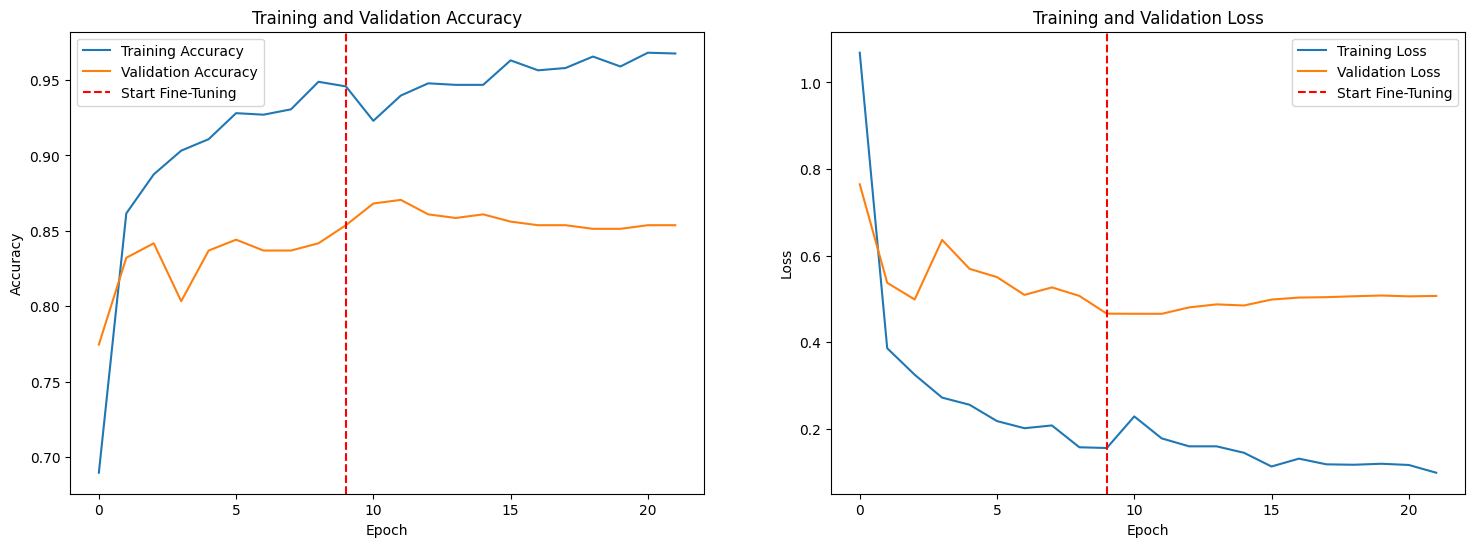


--- Test Set Evaluation ---


 1/14 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.7812 - loss: 0.5989

 2/14 ━━━━━━━━━━━━━━━━━━━━ 4s 362ms/step - accuracy: 0.8125 - loss: 0.5012

 3/14 ━━━━━━━━━━━━━━━━━━━━ 3s 348ms/step - accuracy: 0.8299 - loss: 0.4598

 4/14 ━━━━━━━━━━━━━━━━━━━━ 3s 348ms/step - accuracy: 0.8431 - loss: 0.4259

 5/14 ━━━━━━━━━━━━━━━━━━━━ 3s 342ms/step - accuracy: 0.8507 - loss: 0.4084

 6/14 ━━━━━━━━━━━━━━━━━━━━ 2s 338ms/step - accuracy: 0.8548 - loss: 0.4028

 7/14 ━━━━━━━━━━━━━━━━━━━━ 2s 337ms/step - accuracy: 0.8570 - loss: 0.4003

 8/14 ━━━━━━━━━━━━━━━━━━━━ 2s 335ms/step - accuracy: 0.8588 - loss: 0.4020

 9/14 ━━━━━━━━━━━━━━━━━━━━ 1s 335ms/step - accuracy: 0.8602 - loss: 0.4043

10/14 ━━━━━━━━━━━━━━━━━━━━ 1s 334ms/step - accuracy: 0.8611 - loss: 0.4072

11/14 ━━━━━━━━━━━━━━━━━━━━ 1s 334ms/step - accuracy: 0.8623 - loss: 0.4077

12/14 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.8636 - loss: 0.4068

13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.8648 - loss: 0.4053

14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 311ms/step - accuracy: 0.8801 - loss: 0.3870


Test Accuracy: 88.01%
Test Loss: 0.3870


 1/14 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step

 2/14 ━━━━━━━━━━━━━━━━━━━━ 4s 342ms/step

 3/14 ━━━━━━━━━━━━━━━━━━━━ 3s 337ms/step

 4/14 ━━━━━━━━━━━━━━━━━━━━ 3s 334ms/step

 5/14 ━━━━━━━━━━━━━━━━━━━━ 2s 331ms/step

 6/14 ━━━━━━━━━━━━━━━━━━━━ 2s 331ms/step

 7/14 ━━━━━━━━━━━━━━━━━━━━ 2s 334ms/step

 8/14 ━━━━━━━━━━━━━━━━━━━━ 1s 333ms/step

 9/14 ━━━━━━━━━━━━━━━━━━━━ 1s 332ms/step

10/14 ━━━━━━━━━━━━━━━━━━━━ 1s 332ms/step

11/14 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step

12/14 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step

13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step

14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 395ms/step



--- Confusion Matrix ---


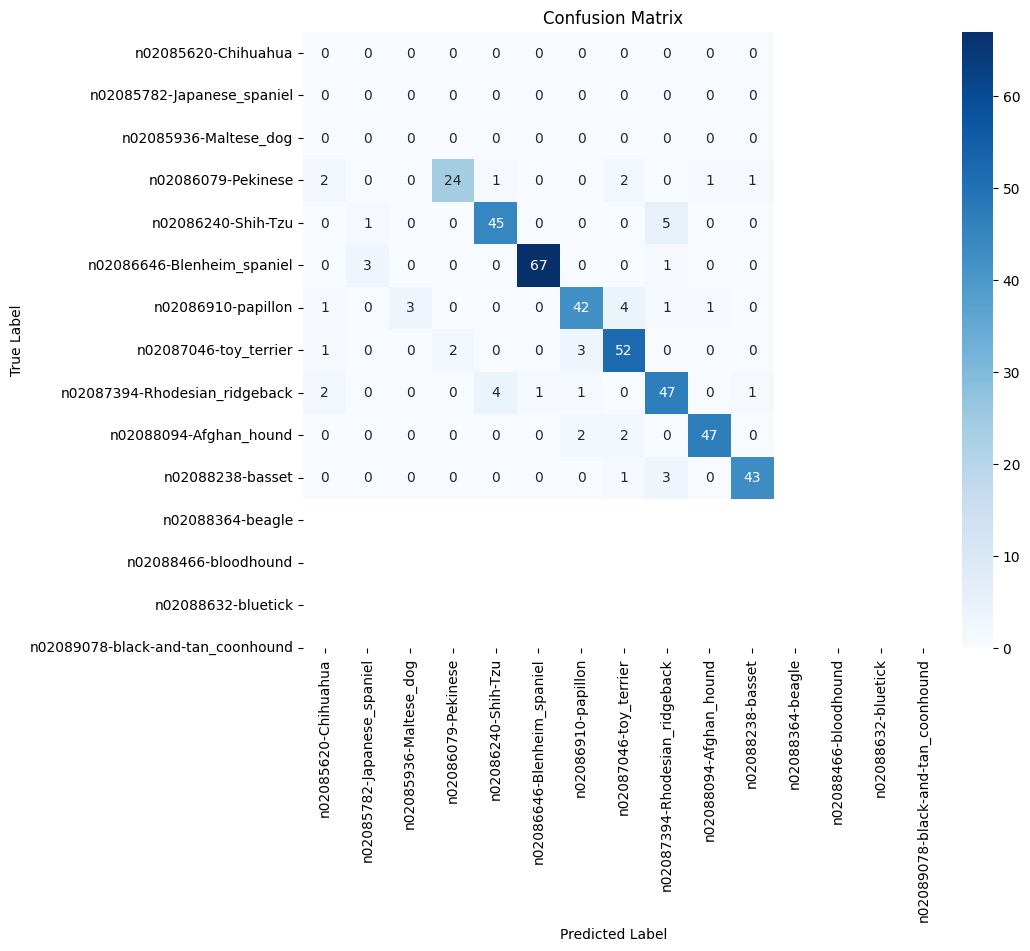


--- Classification Report ---
                     precision    recall  f1-score   support

          Chihuahua       0.00      0.00      0.00         0
   Japanese_spaniel       0.00      0.00      0.00         0
        Maltese_dog       0.00      0.00      0.00         0
           Pekinese       0.00      0.00      0.00         0
                Tzu       0.00      0.00      0.00         0
   Blenheim_spaniel       0.00      0.00      0.00         0
           papillon       0.00      0.00      0.00         0
        toy_terrier       0.92      0.77      0.84        31
Rhodesian_ridgeback       0.90      0.88      0.89        51
       Afghan_hound       0.99      0.94      0.96        71
             basset       0.88      0.81      0.84        52
             beagle       0.85      0.90      0.87        58
         bloodhound       0.82      0.84      0.83        56
           bluetick       0.96      0.92      0.94        51
      tan_coonhound       0.96      0.91      0.93   

In [5]:
print("\n--- Task 4: Analysis & Evaluation ---")

# 1. Plot Training & Validation Curves
def plot_history(history_list):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    
    # Combine histories
    acc = np.concatenate([h.history['accuracy'] for h in history_list])
    val_acc = np.concatenate([h.history['val_accuracy'] for h in history_list])
    loss = np.concatenate([h.history['loss'] for h in history_list])
    val_loss = np.concatenate([h.history['val_loss'] for h in history_list])
    
    # Plot accuracy
    ax1.plot(acc, label='Training Accuracy')
    ax1.plot(val_acc, label='Validation Accuracy')
    ax1.axvline(history_list[0].epoch[-1], color='red', linestyle='--', label='Start Fine-Tuning')
    ax1.set_title('Training and Validation Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    
    # Plot loss
    ax2.plot(loss, label='Training Loss')
    ax2.plot(val_loss, label='Validation Loss')
    ax2.axvline(history_list[0].epoch[-1], color='red', linestyle='--', label='Start Fine-Tuning')
    ax2.set_title('Training and Validation Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    
    plt.savefig('history_curves.png') # Save the plot
    plt.show()

plot_history([history_phase1, history_phase2])

# 2. Evaluate on Test Set
print("\n--- Test Set Evaluation ---")
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# 3. Confusion Matrix & Classification Report
# Generate predictions
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Generate Confusion Matrix
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('confusion_matrix.png') # Save the plot
plt.show()

# Generate Classification Report
print("\n--- Classification Report ---")
# Shorten the class names for the report
short_class_names = [name.split('-')[-1] for name in CLASS_NAMES]

# --- THIS IS THE FIX ---
# We add `labels=list(range(NUM_BREEDS))` to force it to report on all 15 classes.
print(classification_report(y_test, y_pred, 
                            labels=list(range(NUM_BREEDS)), # <-- ADD THIS
                            target_names=short_class_names,
                            zero_division=0)) # Also add zero_division